Porcentaje de área defectuosa: 0.25%
Resultado del análisis: 🟩 Fruta en buen estado


c:\Users\hugoh\OneDrive\Escritorio\Vision\Entorno-Proyecto\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


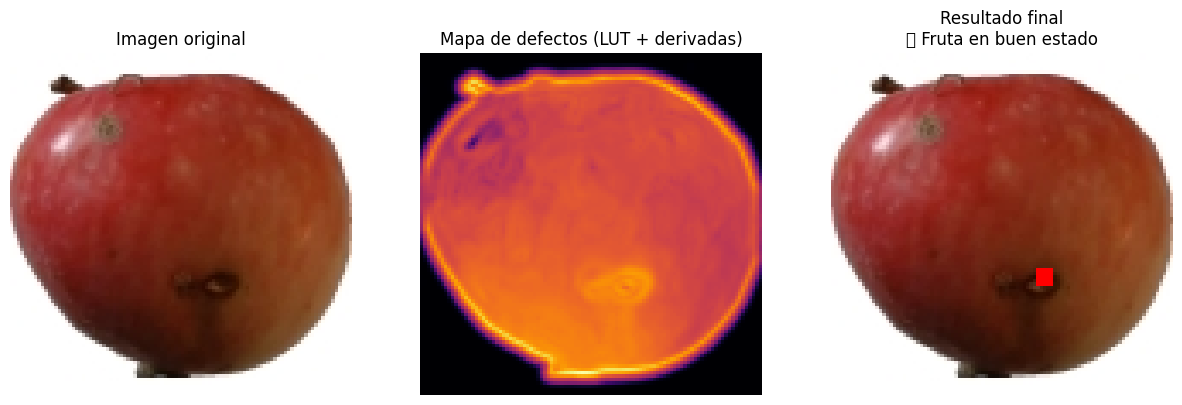

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ================================
# 1. Cargar la imagen
# ================================
# Cambia estos nombres por los tuyos si hace falta
imagen_path = "ManzanaM.jpg"  # o "ManzanaB.jpg" para probar una buena

img = cv2.imread(imagen_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ================================
# 2. Convertir a escala de grises y suavizar
# ================================
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

# ================================
# 3. Calcular derivadas (Sobel o Laplaciano)
# ================================
sobelx = cv2.Sobel(gray_blur, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_blur, cv2.CV_64F, 0, 1, ksize=3)
gradiente = cv2.magnitude(sobelx, sobely)
gradiente = cv2.convertScaleAbs(gradiente)

# ================================
# 4. Crear una Look-Up Table (LUT)
#    combinando oscuridad + borde fuerte
# ================================
# Normalizamos los valores a 0-255
gray_norm = cv2.normalize(gray_blur, None, 0, 255, cv2.NORM_MINMAX)
grad_norm = cv2.normalize(gradiente, None, 0, 255, cv2.NORM_MINMAX)

# LUT: puntuación de defecto
# defect_score = alto si (zona oscura) y (borde fuerte)
defect_score = cv2.addWeighted(255 - gray_norm, 0.7, grad_norm, 0.3, 0)

# ================================
# 5. Umbral para crear máscara de defectos
# ================================
_, defect_mask = cv2.threshold(defect_score, 180, 255, cv2.THRESH_BINARY)

# Eliminamos ruido
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

# ================================
# 6. Calcular porcentaje de área defectuosa
# ================================
total_pixels = gray.shape[0] * gray.shape[1]
defect_pixels = cv2.countNonZero(defect_mask)
porcentaje_defecto = (defect_pixels / total_pixels) * 100

estado = "🟩 Fruta en buen estado"
if porcentaje_defecto > 35:
    estado = "🟥 Fruta en mal estado"

print(f"Porcentaje de área defectuosa: {porcentaje_defecto:.2f}%")
print(f"Resultado del análisis: {estado}")

# ================================
# 7. Mostrar los resultados
# ================================
# Resaltamos las zonas defectuosas en rojo
resultado = img_rgb.copy()
resultado[defect_mask > 0] = [255, 0, 0]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Imagen original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Mapa de defectos (LUT + derivadas)")
plt.imshow(defect_score, cmap="inferno")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Resultado final\n{estado}")
plt.imshow(resultado)
plt.axis("off")

plt.show()


Queremos poder analizar las frutas que pueden haber en una fábrica para conocer si estas están en buen estado para la venta de estas, o si por el contrario necesitaríamos tirarla ya que esta se encuentra en mal estado y no sería recomendable su venta.

Comenzaremos mostrando la imagen de la manzana buena, que nos indicaría como sería la manzana perfecta para su venta, y al lado una manzana en mal estado para comprobar que esta no se podría llegar a vender por sus fallos.

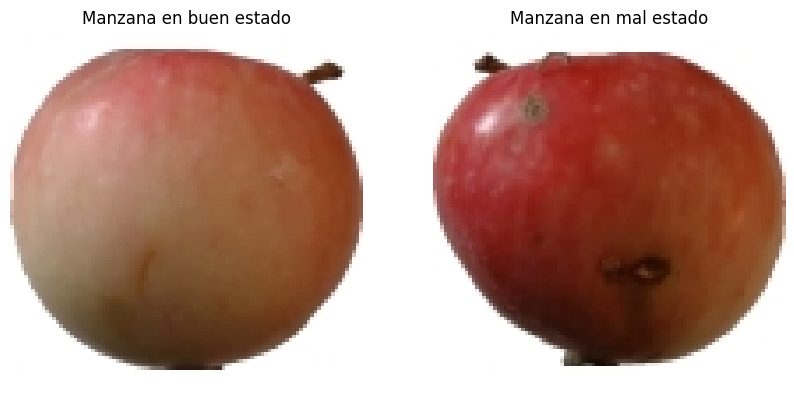

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Mostramos la imagen de la manzana buena y la mala lado a lado
img_buena = cv2.imread("ManzanaB.jpg")
img_mala = cv2.imread("ManzanaM.jpg")
img_buena_rgb = cv2.cvtColor(img_buena, cv2.COLOR_BGR2RGB)
img_mala_rgb = cv2.cvtColor(img_mala, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Manzana en buen estado")
plt.imshow(img_buena_rgb)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Manzana en mal estado")
plt.imshow(img_mala_rgb)
plt.axis("off")
plt.show()

Una vez mostradas las imágenes, las convertimos a la escala de grises para poder verlas mejor y las suavizamos para eliminar todo tipo de errores.

Usamos un suavizado Gaussiano para el suavizado de la imagen, esta se lleva a cabo mediante una operación de convolución, donde se utiliza un kernel. En primer lugar:

    - Nos calcula un promedio ponderado de todos los valores de los píxeles vecinos.
    - El kernel es una pequeña matriz de números donde el píxel central recibe el peso más alto, y los pesos de los vecinos van disminuyendo gradualmente a medida que se alejan del centro.

Al aplicar el ponderado a cada píxel, los cambios bruscos de intensidad se suavizan, ya que los valores de los píxeles de los extremos se atenuan por el promedio de sus vecinos cercanos.

Esto nos ayuda a mejorar la detección de los bordes y las regiones oscuras reales.

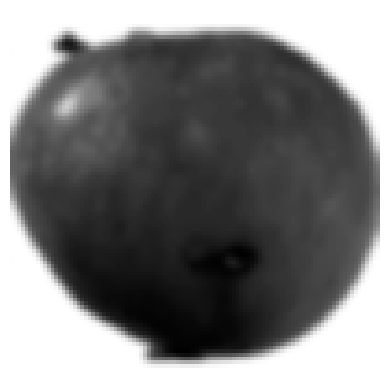

In [ ]:
gray = cv2.cvtColor(img_mala, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

plt.imshow(gray_blur, cmap='gray')
plt.axis("off")
plt.show()

Una vez hemos suavizado la imagen, pasamos a calcular las derivadas usando Sobel.
Aplicamos la derivada tanto para el eje X como para el eje Y, estas nos indican dónde cambia la intensidad de una manera muy brusca.

Si combinamos ambas magnitudes, podremos obtener la zona de cambios fuertes de textura, donde podremos encontrar la zona "mala" de la fruta.

Nos sirve mucho aplicar la derivada ya que los agujeros o las zonas podridas en frutas normalmente suelen tener los bordes marcados por el contraste, por lo que este método nos enseñará las zonas con agujeros que existen en la fruta.

In [14]:
sobelx = cv2.Sobel(gray_blur, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_blur, cv2.CV_64F, 0, 1, ksize=3)
gradiente = cv2.magnitude(sobelx, sobely)
gradiente = cv2.convertScaleAbs(gradiente)

Porcentaje de área defectuosa: 0.25%
Resultado del análisis: 🟩 Fruta en buen estado


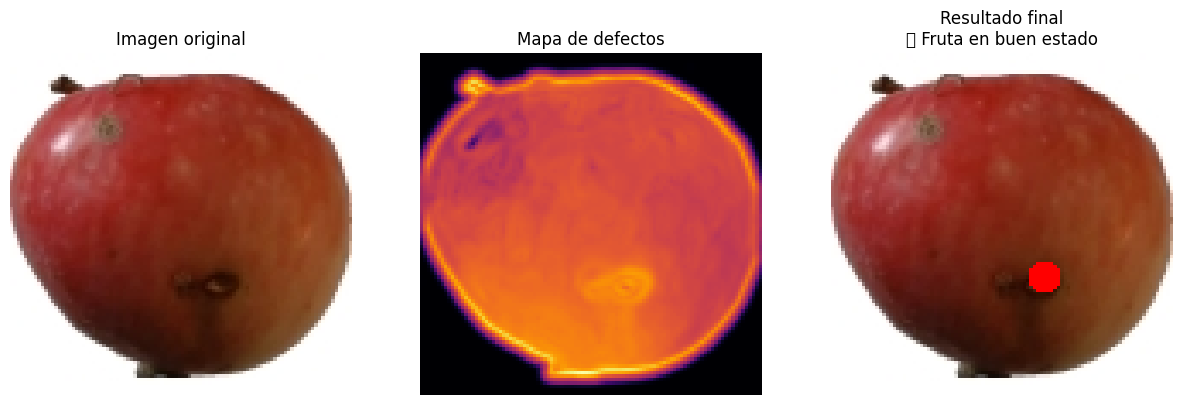

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ================================
# 1. Cargar la imagen
# ================================
imagen_path = "ManzanaM.jpg"  # Cambia a ManzanaB.jpg para probar una buena
img = cv2.imread(imagen_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ================================
# 2. Convertir a escala de grises y suavizar
# ================================
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

# ================================
# 3. Calcular derivadas (Sobel)
# ================================
sobelx = cv2.Sobel(gray_blur, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_blur, cv2.CV_64F, 0, 1, ksize=3)
gradiente = cv2.magnitude(sobelx, sobely)
gradiente = cv2.convertScaleAbs(gradiente)

# ================================
# 4. Crear Look-Up Table (LUT)
# ================================
gray_norm = cv2.normalize(gray_blur, None, 0, 255, cv2.NORM_MINMAX)
grad_norm = cv2.normalize(gradiente, None, 0, 255, cv2.NORM_MINMAX)

defect_score = cv2.addWeighted(255 - gray_norm, 0.7, grad_norm, 0.3, 0)

# ================================
# 5. Máscara de zonas defectuosas
# ================================
_, defect_mask = cv2.threshold(defect_score, 180, 255, cv2.THRESH_BINARY)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

# ================================
# 6. Calcular porcentaje de área defectuosa
# ================================
total_pixels = gray.shape[0] * gray.shape[1]
defect_pixels = cv2.countNonZero(defect_mask)
porcentaje_defecto = (defect_pixels / total_pixels) * 100

estado = "🟩 Fruta en buen estado"
if porcentaje_defecto > 35:
    estado = "🟥 Fruta en mal estado"

print(f"Porcentaje de área defectuosa: {porcentaje_defecto:.2f}%")
print(f"Resultado del análisis: {estado}")

# ================================
# 7. Dibujar contornos de defectos
# ================================
resultado = img_rgb.copy()
contornos, _ = cv2.findContours(defect_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujamos los contornos detectados en rojo
cv2.drawContours(resultado, contornos, -1, (255, 0, 0), thickness=3)

# ================================
# 8. Mostrar resultados
# ================================
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Imagen original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Mapa de defectos")
plt.imshow(defect_score, cmap="inferno")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Resultado final\n{estado}")
plt.imshow(resultado)
plt.axis("off")

plt.show()
